# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico III 


### NOTEBOOK No 2: Models 

# Note
This notebook has models for genre classification task that use the default values of the hyperparameters.
In order to not make a too-long notebook, the gridsearched models are in Notebook No 3.

### Librerías

In [44]:
%%capture
!pip3 install pandas
!pip3 install spacy
!pip3 install nltk
!pip3 install seaborn
!pip3 install requests
!pip3 install nltk
!pip3 install tqdm
!pip3 install plotly
!pip3 install sklearn
!pip3 install tensorflow

# Agregar las librerías extra que se utilicen en esta celda y la siguiente

### Dependencias y acceso a APIs

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm
import plotly.express as px
import plotly.graph_objects as go
import requests
from collections import Counter
from nltk import ngrams, bigrams
import nltk
import itertools
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from statistics import median,mean
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

sns.set_context(context='paper')

## Music Features

In [46]:
#Aux funcs
def genres_by_artist_id(id): #id: str
    artist = sp.artist(id)
    genres = artist['genres']
    return genres    #genres: List[str]

def songs_from_album_id(album_id):
    songs = []
    album = sp.album(album_id)
    artist = album['artists'][0]['name']
    for item in album['tracks']['items']:
        track = {}
        track["song_name"] = item['name']
        track["song_id"] = item['id']
        track["album_name"] = album['name']
        track["album_id"] = album["id"]
        audio_features = sp.audio_features(track["song_id"])
        track["audio_features"] = audio_features[0]
        track["artist"] = artist
        songs.append(track)
    return songs    #songs:List[dict]

def get_genres(artists_id):
    res = [genres_by_artist_id(x) for x in artists_id if genres_by_artist_id(x)!= []]
    if res != []:
        return res[0]
    return res

def add_track(track_id, songs): #track_id:str, songs:List[dict]
    track = sp.track(track_id)
    audio_features = sp.audio_features(track_id)
    row = {}
    row["song_name"] = track['name']
    row["song_id"] = track['id']
    row["artists"] = [x["name"] for x in track["artists"]]
    row["artists_id"] = [x["id"] for x in track["artists"]]
    row["album_name"] = track['album']['name']
    row["album_id"] = track['album']['id']
    row["audio_features"] = audio_features[0]
    row["genres"] = get_genres(row["artists_id"])
    songs.append(row)
    return songs

def track_by_feature(feature, value):
    track_id = audio_features_base[audio_features_base[feature]==value]['id']
    track_id = track_id.values.item(0)
    return df[df['song_id']== track_id]
#example use: 
#print(track_by_feature("valence",0.039100))
#track_by_feature("speechiness",0.492000)

def songs_of_description(statistic):
    row = audio_features_description.loc[statistic]
    keys = row.keys()
    tracks_of_row = []
    for key in keys:
        track = track_by_feature(key,row[key]).to_dict()['song_name']
        track = list(track.values())[0]
        tracks_of_row.append({key: track})
    return tracks_of_row
#example use
#songs_of_description("min")

#songs_of_description("max")

## Dataset
starting from here we have a full Dataset with all the track of the playlist plus audio features and the pre-processed sentiment analysis variable


In [47]:
songs_base = pd.read_csv("./final_big.csv",sep="#")
#let's get back our genres
songs_base["genres"]=songs_base["genres"].apply(lambda x: x.replace("[","").replace("]","").replace("'","").split(","))
songs_base["artists"]=songs_base["artists"].apply(lambda x: x.replace("[","").replace("]","").replace("'","").split(","))

In [48]:
songs_base.shape

(920, 9)

In [49]:
songs_base.head(1)

,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key': 1, 'loudness': -11.21, 'mode': 0, 'speechiness': 0.0472, 'acousticness': 0.486, 'instrumentalness': 0.409, 'liveness': 0.371, 'valence': 0.0926, 'tempo': 161.092, 'type': 'audio_features', 'id': '7j9DYPyCuvSAtPcevpAkzb', 'uri': 'spotify:track:7j9DYPyCuvSAtPcevpAkzb', 'track_href': 'https://api.spotify.com/v1/tracks/7j9DYPyCuvSAtPcevpAkzb', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7j9DYPyCuvSAtPcevpAkzb', 'duration_ms': 233079, 'time_signature': 5}","[art pop, dance pop, deconstructed club, electropop, escape room, experimental pop, fluxwork, indie r&b, indietronica]",0.0013


In [50]:
my_dataframe=songs_base.copy()

In [51]:
#SPLIT AUDIO FEATURES
import ast

audio_thing= my_dataframe["audio_features"].apply(lambda x: ast.literal_eval(x))
audio_features_base = pd.DataFrame(list(audio_thing))
audio_features = audio_features_base.columns

my_dataframe = my_dataframe.reset_index(drop=True)
audio_features_base = audio_features_base.reset_index(drop=True)
my_dataframe = pd.concat([my_dataframe,audio_features_base],axis=1)
print(my_dataframe.shape)
my_dataframe.head(1)

(920, 27)


,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key': 1, 'loudness': -11.21, 'mode': 0, 'speechiness': 0.0472, 'acousticness': 0.486, 'instrumentalness': 0.409, 'liveness': 0.371, 'valence': 0.0926, 'tempo': 161.092, 'type': 'audio_features', 'id': '7j9DYPyCuvSAtPcevpAkzb', 'uri': 'spotify:track:7j9DYPyCuvSAtPcevpAkzb', 'track_href': 'https://api.spotify.com/v1/tracks/7j9DYPyCuvSAtPcevpAkzb', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7j9DYPyCuvSAtPcevpAkzb', 'duration_ms': 233079, 'time_signature': 5}","[art pop, dance pop, deconstructed club, electropop, escape room, experimental pop, fluxwork, indie r&b, indietronica]",0.0013,0.161,0.482,1,-11.21,0,0.0472,0.486,0.409,0.371,0.0926,161.092,audio_features,7j9DYPyCuvSAtPcevpAkzb,spotify:track:7j9DYPyCuvSAtPcevpAkzb,https://api.spotify.com/v1/tracks/7j9DYPyCuvSAtPcevpAkzb,https://api.spotify.com/v1/audio-analysis/7j9DYPyCuvSAtPcevpAkzb,233079,5


In [52]:
#EXTRACT FIRST ARTIST
my_dataframe1 = my_dataframe.copy()
my_dataframe1["first_artist"] = my_dataframe1["artists"].apply(lambda x: x[0])
print(my_dataframe1.shape)

(920, 28)


problem with spotify's genres (target): **multiple genres in the same song**

Examples:

In [53]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
my_dataframe1['genres'].head(6)

0    [art pop,  dance pop,  deconstructed club,  electropop,  escape room,  experimental pop,  fluxwork,  indie r&b,  indietronica]
1    [art pop,  dance pop,  deconstructed club,  electropop,  escape room,  experimental pop,  fluxwork,  indie r&b,  indietronica]
2    [art pop,  dance pop,  deconstructed club,  electropop,  escape room,  experimental pop,  fluxwork,  indie r&b,  indietronica]
3    [bolero,  cancion melodica,  grupera,  latin,  latin pop,  ranchera]                                                          
4    [cancion melodica,  latin,  latin pop]                                                                                        
5    [argentine heavy metal,  argentine metal,  argentine rock,  latin metal,  rock en espanol,  rock nacional]                    
Name: genres, dtype: object

We followed to principles to see how that would perform:
- first we solved this by deciding to select the first genre of the list, from which we create a new column in our dataframe called first_genre
- later on we use the full list of genres, transforming this into a multiclass multilabel problem.

In [54]:
#FIRST GENRE
my_dataframe2 = my_dataframe1.copy()
my_dataframe2["first_genre"] = my_dataframe2["genres"].apply(lambda x: x[0])
print(my_dataframe2.shape)
my_dataframe2.head(1)

(920, 29)


,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,first_artist,first_genre
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key': 1, 'loudness': -11.21, 'mode': 0, 'speechiness': 0.0472, 'acousticness': 0.486, 'instrumentalness': 0.409, 'liveness': 0.371, 'valence': 0.0926, 'tempo': 161.092, 'type': 'audio_features', 'id': '7j9DYPyCuvSAtPcevpAkzb', 'uri': 'spotify:track:7j9DYPyCuvSAtPcevpAkzb', 'track_href': 'https://api.spotify.com/v1/tracks/7j9DYPyCuvSAtPcevpAkzb', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7j9DYPyCuvSAtPcevpAkzb', 'duration_ms': 233079, 'time_signature': 5}","[art pop, dance pop, deconstructed club, electropop, escape room, experimental pop, fluxwork, indie r&b, indietronica]",0.0013,0.161,0.482,1,-11.21,0,0.0472,0.486,0.409,0.371,0.0926,161.092,audio_features,7j9DYPyCuvSAtPcevpAkzb,spotify:track:7j9DYPyCuvSAtPcevpAkzb,https://api.spotify.com/v1/tracks/7j9DYPyCuvSAtPcevpAkzb,https://api.spotify.com/v1/audio-analysis/7j9DYPyCuvSAtPcevpAkzb,233079,5,Arca,art pop


some statistics on the dataset features

In [55]:
my_dataframe2.describe()

,lyrics_sentiment,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000
mean,0.130122,0.581547,0.726554,5.356522,-6.456889,0.621739,0.067269,0.225279,0.017218,0.222746,0.598111,125.971299,231888.272826,3.953261
std,0.312527,0.150456,0.177867,3.536697,2.732719,0.485217,0.062840,0.233056,0.097245,0.200685,0.228758,29.881469,54274.437533,0.265929
min,0.000000,0.148000,0.107000,0.000000,-19.575000,0.000000,0.022100,0.000004,0.000000,0.027700,0.037700,60.026000,65183.000000,1.000000
25%,0.000000,0.487500,0.612500,2.000000,-7.655250,0.000000,0.031600,0.034425,0.000000,0.094600,0.414750,98.008000,197063.500000,4.000000
50%,0.000000,0.598500,0.763000,5.500000,-5.991500,1.000000,0.043750,0.138000,0.000001,0.139500,0.623000,127.971000,226945.500000,4.000000
75%,0.001200,0.692250,0.869000,9.000000,-4.619000,1.000000,0.073200,0.351500,0.000112,0.296000,0.790000,147.163250,260803.250000,4.000000
max,1.000000,0.945000,0.995000,11.000000,-1.681000,1.000000,0.514000,0.954000,0.944000,0.982000,0.976000,204.498000,556427.000000,5.000000


ENCODING GENRES

In [56]:
my_dataframe3=my_dataframe2.copy()
from sklearn.preprocessing import LabelEncoder
# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(my_dataframe3["first_genre"])
my_dataframe3["encoded_genres"]= label_encoder.transform(my_dataframe3["first_genre"])
print("Shape of the full Dataframe:", my_dataframe3.shape)
print("\nValidamos...")
print("Cantidad total de elementos en el target first genres:" , len(my_dataframe3['first_genre']))
print("Cantidad total de elementos en el target encoded genres:" , len(my_dataframe3['encoded_genres']))
print("\nClases únicas en el target first genres: ", my_dataframe3['first_genre'].nunique())
print("Clases únicas en el target encoded genres: ", my_dataframe3['encoded_genres'].nunique())
print("\nElementos a predecir en el target: \n",my_dataframe3['encoded_genres'].unique())



Shape of the full Dataframe: (920, 30)

Validamos...
Cantidad total de elementos en el target first genres: 920
Cantidad total de elementos en el target encoded genres: 920

Clases únicas en el target first genres:  39
Clases únicas en el target encoded genres:  39

Elementos a predecir en el target: 
 [ 9 11 12  2 13  8 18 28  6 14 30 33 36 27 16 34 19  1 29  4  3 35  0 32
 23 31  5  7 25 26 17 21 37 20 24 38 15 22 10]


#### This is the full Dataframe that we get

In [57]:
dataframe_working=my_dataframe3.copy()
pd.set_option('display.max_columns', None)
print(dataframe_working.shape)
dataframe_working.head(2)

(920, 30)


,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,first_artist,first_genre,encoded_genres
0,Desafío,7j9DYPyCuvSAtPcevpAkzb,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.161, 'energy': 0.482, 'key': 1, 'loudness': -11.21, 'mode': 0, 'speechiness': 0.0472, 'acousticness': 0.486, 'instrumentalness': 0.409, 'liveness': 0.371, 'valence': 0.0926, 'tempo': 161.092, 'type': 'audio_features', 'id': '7j9DYPyCuvSAtPcevpAkzb', 'uri': 'spotify:track:7j9DYPyCuvSAtPcevpAkzb', 'track_href': 'https://api.spotify.com/v1/tracks/7j9DYPyCuvSAtPcevpAkzb', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7j9DYPyCuvSAtPcevpAkzb', 'duration_ms': 233079, 'time_signature': 5}","[art pop, dance pop, deconstructed club, electropop, escape room, experimental pop, fluxwork, indie r&b, indietronica]",0.0013,0.161,0.482,1,-11.210,0,0.0472,0.486,0.409,0.371,0.0926,161.092,audio_features,7j9DYPyCuvSAtPcevpAkzb,spotify:track:7j9DYPyCuvSAtPcevpAkzb,https://api.spotify.com/v1/tracks/7j9DYPyCuvSAtPcevpAkzb,https://api.spotify.com/v1/audio-analysis/7j9DYPyCuvSAtPcevpAkzb,233079,5,Arca,art pop,9
1,Anoche,1cwTMSQeMaA9fVKEF1iWeD,[Arca],['4SQdUpG4f7UbkJG3cJ2Iyj'],Arca,1MQO4j8QExVgmnplbIodEU,"{'danceability': 0.23, 'energy': 0.434, 'key': 10, 'loudness': -12.402, 'mode': 0, 'speechiness': 0.0551, 'acousticness': 0.57, 'instrumentalness': 0, 'liveness': 0.115, 'valence': 0.0834, 'tempo': 80.793, 'type': 'audio_features', 'id': '1cwTMSQeMaA9fVKEF1iWeD', 'uri': 'spotify:track:1cwTMSQeMaA9fVKEF1iWeD', 'track_href': 'https://api.spotify.com/v1/tracks/1cwTMSQeMaA9fVKEF1iWeD', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1cwTMSQeMaA9fVKEF1iWeD', 'duration_ms': 216905, 'time_signature': 5}","[art pop, dance pop, deconstructed club, electropop, escape room, experimental pop, fluxwork, indie r&b, indietronica]",0.9970,0.230,0.434,10,-12.402,0,0.0551,0.570,0.000,0.115,0.0834,80.793,audio_features,1cwTMSQeMaA9fVKEF1iWeD,spotify:track:1cwTMSQeMaA9fVKEF1iWeD,https://api.spotify.com/v1/tracks/1cwTMSQeMaA9fVKEF1iWeD,https://api.spotify.com/v1/audio-analysis/1cwTMSQeMaA9fVKEF1iWeD,216905,5,Arca,art pop,9


In [58]:
interesting_features = ["danceability", "energy","key","loudness","mode",
            "speechiness","acousticness","instrumentalness","liveness",
            "valence","tempo","lyrics_sentiment"]

def get_df_for_training(base_df,features=interesting_features):
    df = base_df.copy()
    audio_thing= df["audio_features"].apply(lambda x: ast.literal_eval(x))
    audio_features_base = pd.DataFrame(list(audio_thing))
    audio_features = audio_features_base.columns
    #print(df.count(), " vs ", audio_features_base.count())
    df = df.reset_index(drop=True)
    audio_features_base = audio_features_base.reset_index(drop=True)
    df2 = pd.concat([df,audio_features_base],axis=1)
    other = df2[audio_features].join( df['lyrics_sentiment'])
    sanitized = df2.drop(["uri", "analysis_url", "track_href", "id", "type"],1)

    X = sanitized[features]
    Y = df2["genres"]
    return X,Y

In [59]:
#parameters:axs the sns barplot, h_v = 'h' horizontal barplot or 'v' vertical barplot, space = number of space betweel label and bar
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

## Songs by first unique Artists Distribution

Let's try to simplify the process by using a unique Artist of our dataset for each song, we use the first one.

In [60]:
second_dist = dataframe_working["first_artist"].value_counts()
second_dist_df = pd.DataFrame({'artists':second_dist.index, 'count':second_dist.values})
second_dist_df.shape

(160, 2)

How many unique artist do we have?

In [61]:
second_dist_df['artists'].value_counts().sum()

160

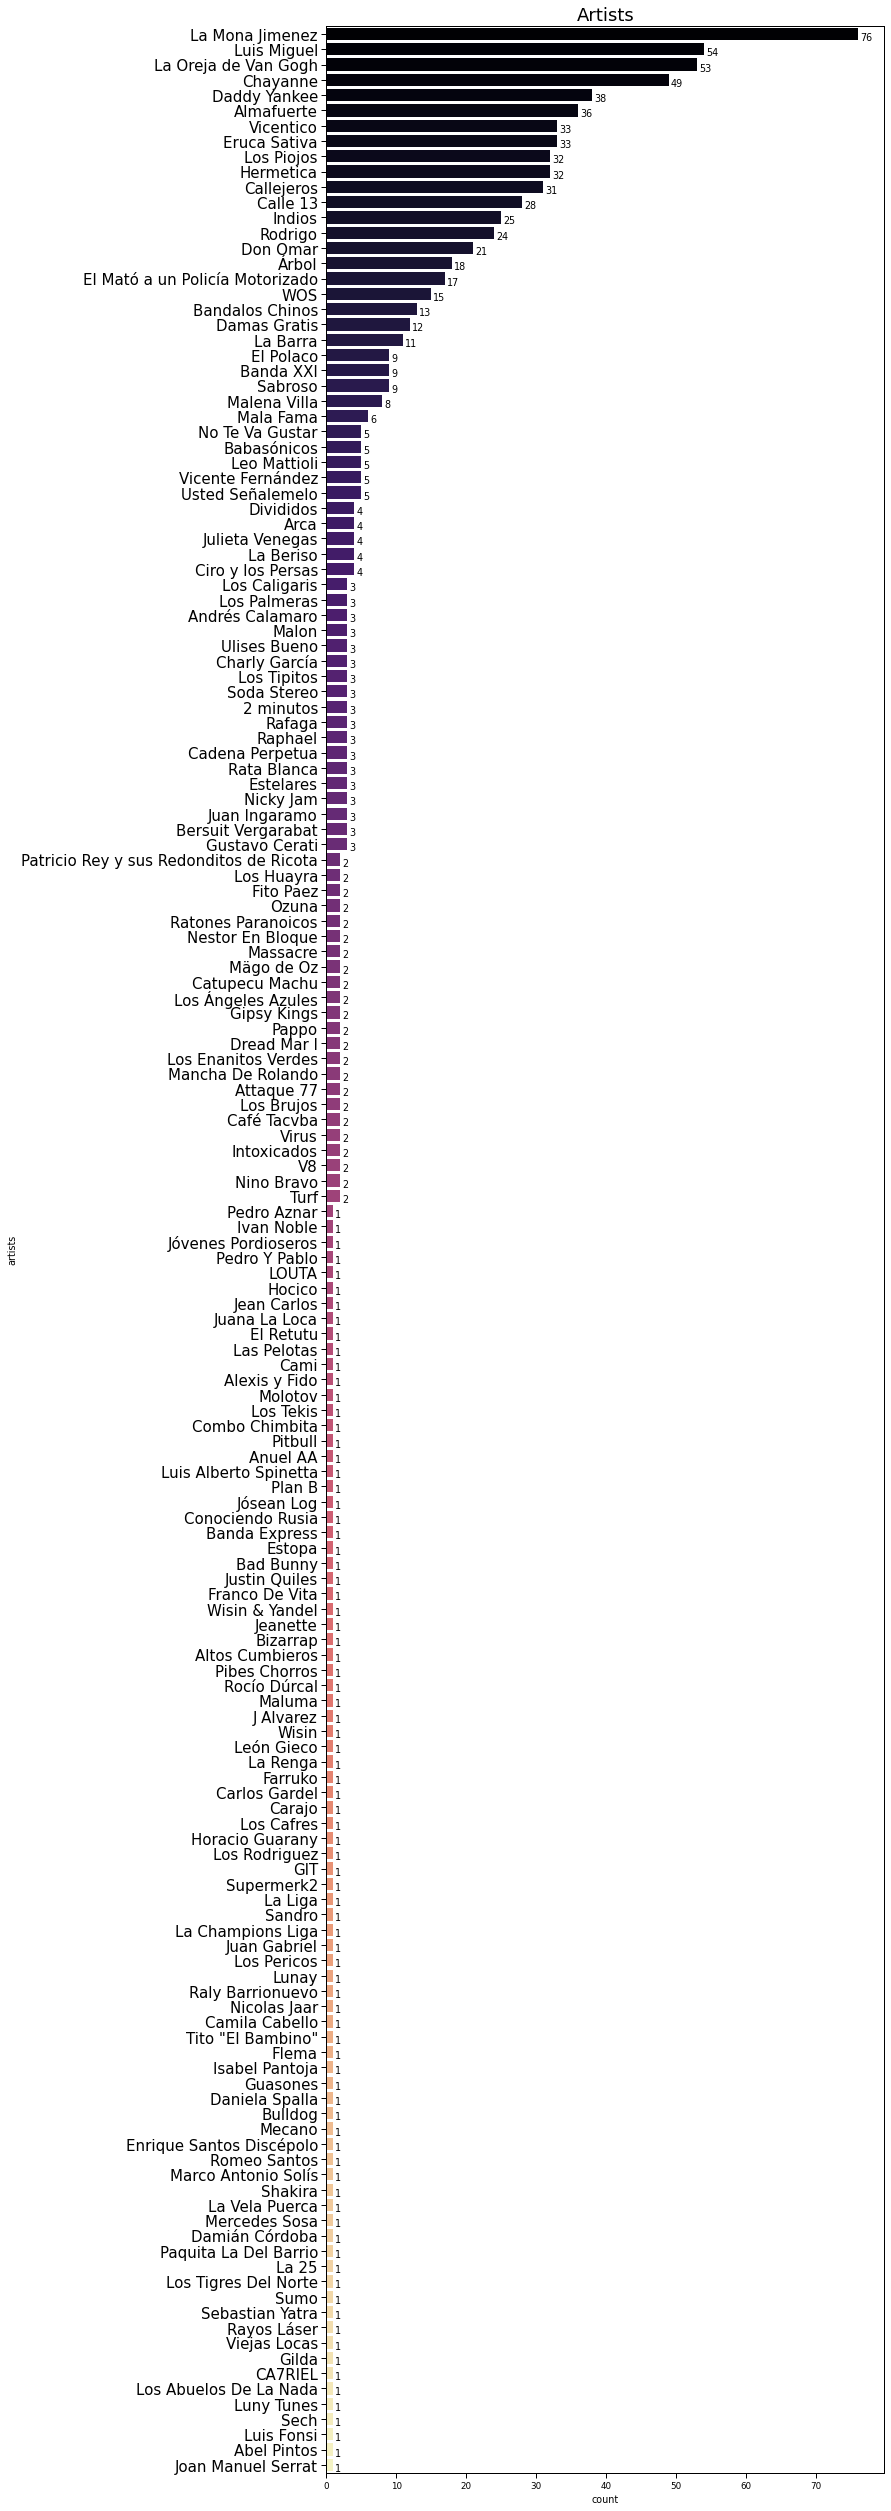

In [62]:
plt.figure(figsize=(10,45))
plt.yticks(size=15)
plt.title('Artists', size=18)
plt.ylabel('')
sns_a=sns.barplot(x=second_dist_df["count"] ,y=second_dist_df["artists"], palette="magma") # GnBu Blues_d Spectral magma 
show_values_on_bars(sns_a, "h", 0.3)

Let's try to simplify the process by using a unique Genre of our dataset for each song, we use the first one.

## Music Genres Distribution

In [63]:
first_dist = dataframe_working["first_genre"].value_counts()
first_dist_df = pd.DataFrame({'genre':first_dist.index, 'count':first_dist.values})
first_dist_df.shape

(39, 2)

How much unique first genres do we have?

In [64]:
first_dist_df['genre'].value_counts().sum()

39

 Full dataset Genre Distribution

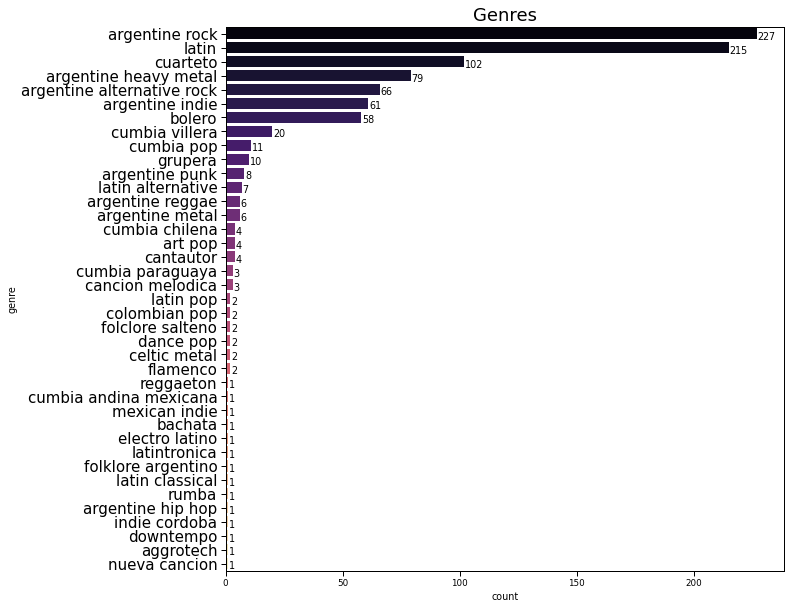

In [65]:
plt.figure(figsize=(10,10))
plt.yticks(size=15)
plt.title('Genres', size=18)
plt.ylabel('')
sns_g=sns.barplot(x=first_dist_df["count"] ,y=first_dist_df["genre"], palette="magma") # GnBu Blues_d Spectral magma 
show_values_on_bars(sns_g, "h", 0.3)

560-----289 --- 920


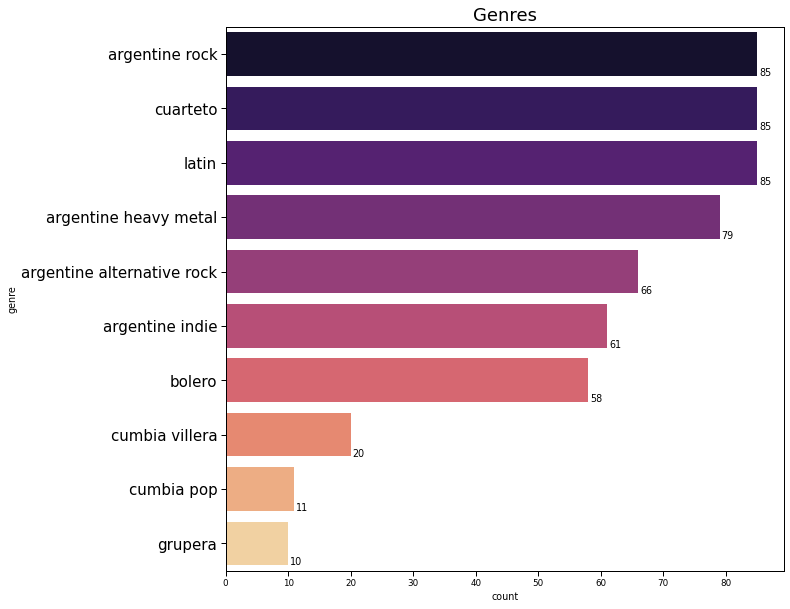

In [148]:

test = first_dist_df.copy()

ds_size = test['count'].sum()
test['percentage'] = test['count'].apply(lambda x : (x * 100 / ds_size))
'''
plt.figure(figsize=(10,10))
plt.yticks(size=15)
plt.title('Genres', size=18)
plt.ylabel('')
sns_g=sns.barplot(x=test["percentege"] ,y=test["genre"], palette="magma") # GnBu Blues_d Spectral magma 
show_values_on_bars(sns_g, "h", 0.3)
'''
genre_perc = test[test['percentage'] > 1]
ds_size = genre_perc['count'].sum()
perc_10 = 10 * ds_size /100
round(perc_10)
ds_work_test = dataframe_working.copy()
ss = ds_work_test.sample(n=100, replace=False, random_state=42)
dataframe_working[dataframe_working['first_genre'] == 'cuarteto']

df_all = dataframe_working.copy()
df_new = pd.DataFrame(columns=df_all.columns)

for index, row in test.iterrows():
    percentage = int(row['percentage'])
    df_genre = df_all[df_all['first_genre'] == row['genre']]
    
    if percentage < 1 :
        df_all = df_all.drop(df_genre.index)
    elif percentage <= 10:
        df_new = df_new.append(df_genre)
        df_all = df_all.drop(df_genre.index)
    elif  percentage > 10:        
        df_temp = df_genre.sample(n=85, random_state=42)
        df_new = df_new.append(df_temp)        
        df_all = df_all.drop(df_temp.index)
        
            
print('{}-----{} --- {}'.format(len(df_new), len(df_all), len(dataframe_working)))
            
first_dist_new = df_new["first_genre"].value_counts()
first_dist_new_df = pd.DataFrame({'genre':first_dist_new.index, 'count':first_dist_new.values})
first_dist_new_df.shape

plt.figure(figsize=(10,10))
plt.yticks(size=15)
plt.title('Genres', size=18)
plt.ylabel('')
sns_g=sns.barplot(x=first_dist_new_df["count"] ,y=first_dist_new_df["genre"], palette="magma") # GnBu Blues_d Spectral magma 
show_values_on_bars(sns_g, "h", 0.3)

 #def balance_df(data_frame):
 #   df_size = len(data_frame)
    


#### Applying some filters in our dataframe
new try removing first three most frequent genres: _Argentine Rock, Latin and Cuarteto_

In [67]:
a_new_try = dataframe_working[dataframe_working["first_genre"] != "argentine rock" ]
a_new_try = a_new_try[a_new_try["first_genre"] != "latin"]
a_new_try = a_new_try[a_new_try["first_genre"] != "cuarteto"]
a_new_try.shape

(376, 30)

In [68]:
new_dist = a_new_try["first_genre"].value_counts()
new_dist_df = pd.DataFrame({'genre':new_dist.index, 'count':new_dist.values})
new_dist_df.shape
print("Now we have", new_dist_df['genre'].value_counts().sum(), "genres")

Now we have 36 genres


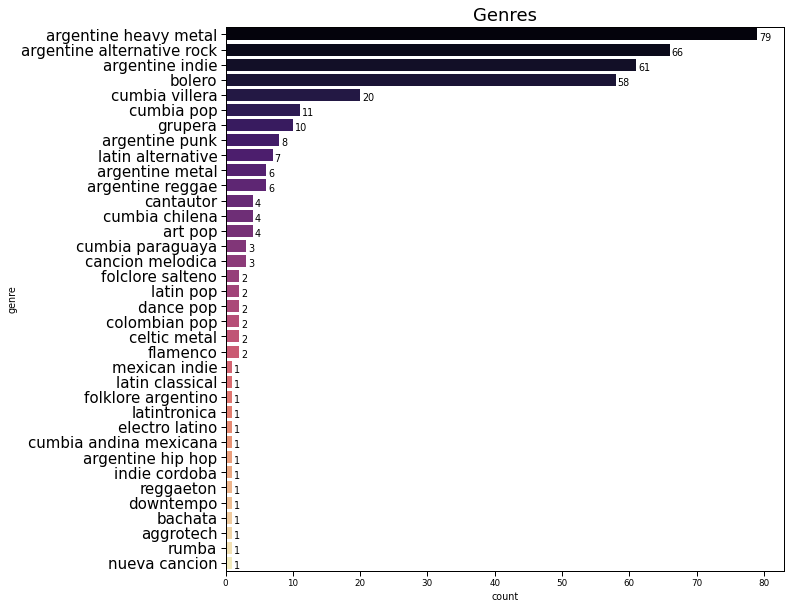

In [69]:
plt.figure(figsize=(10,10))# 14 10
plt.yticks(size=15)
plt.title('Genres', size=18)
plt.ylabel('')
sns_g2=sns.barplot(x=new_dist_df["count"] ,y=new_dist_df["genre"], palette="magma") # GnBu Blues_d Spectral magma 
show_values_on_bars(sns_g2, "h", 0.3)

After removing the three most frequents genres, what artist distribution do we get?

In [70]:
third_dist = a_new_try["first_artist"].value_counts()
third_dist_df = pd.DataFrame({'artists':third_dist.index, 'count':third_dist.values})
third_dist_df.shape

(86, 2)

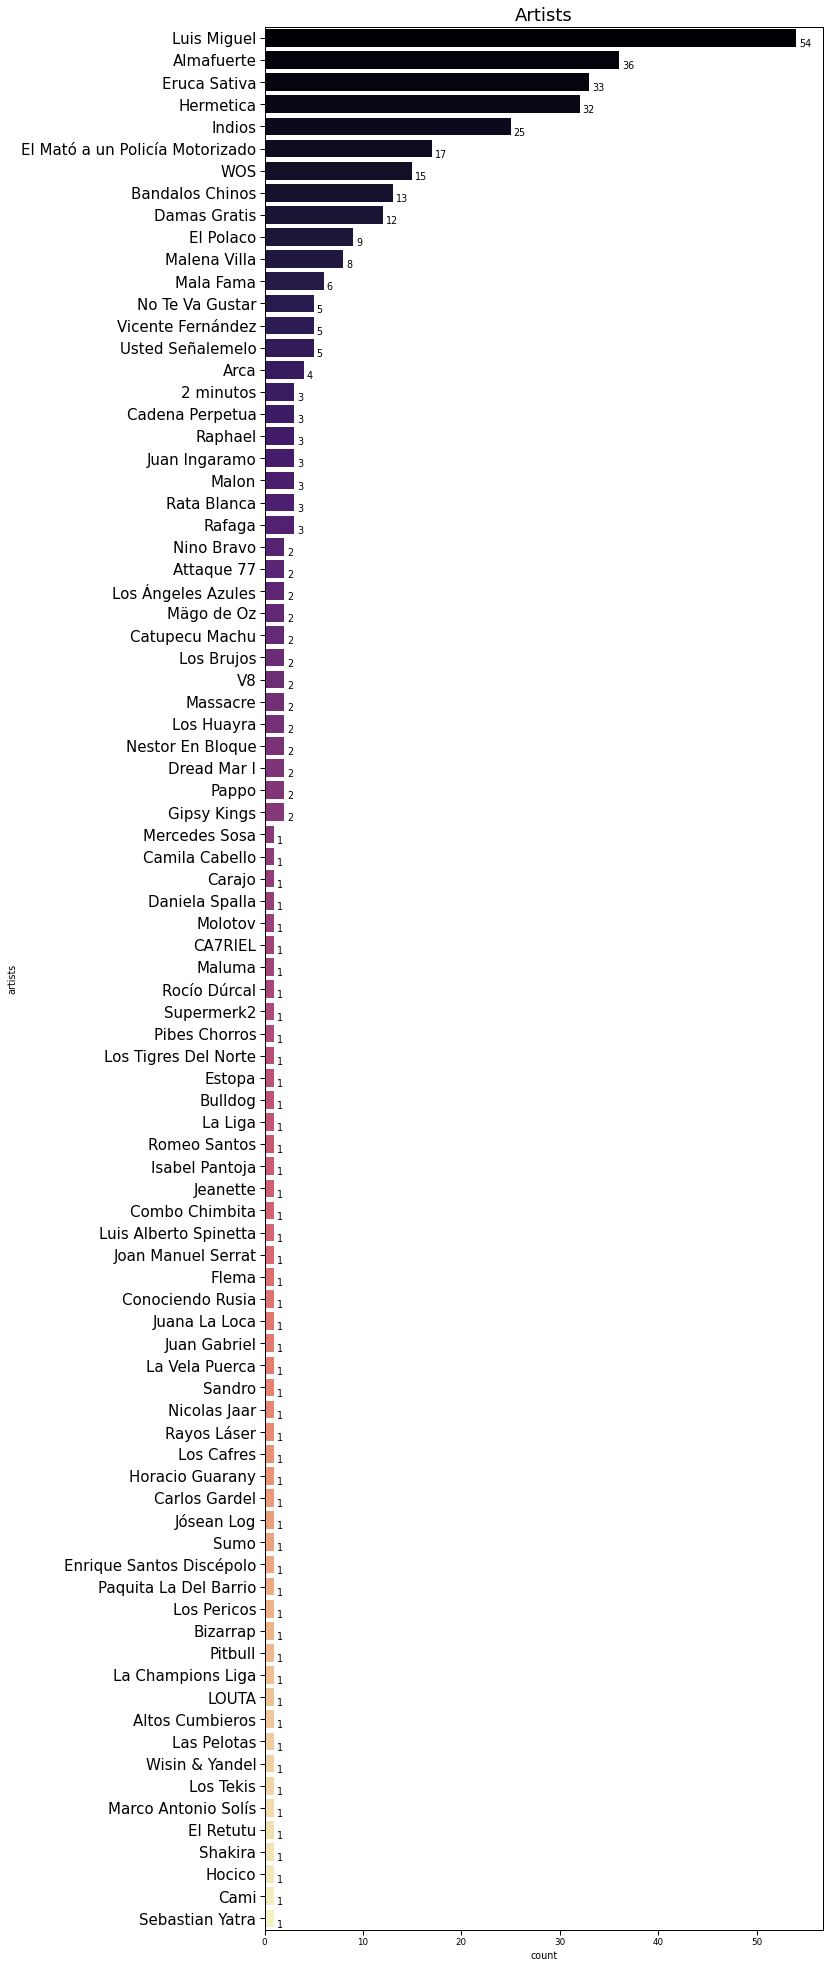

In [71]:
plt.figure(figsize=(10,35)) #12 50
plt.yticks(size=15)
plt.title('Artists', size=18)
plt.ylabel('')
sns_a2=sns.barplot(x=third_dist_df["count"] ,y=third_dist_df["artists"], palette="magma") # GnBu Blues_d Spectral magma 
show_values_on_bars(sns_a2, "h", 0.3)

using a random choice we get a slightly more balanced dataset.

In [28]:
a_new_try.shape

(376, 30)

In [29]:
a_new_try.describe()

,lyrics_sentiment,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,encoded_genres
count,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000
mean,0.164694,0.540513,0.691335,5.223404,-7.055388,0.638298,0.064391,0.231901,0.037004,0.198829,0.529391,121.036032,216348.018617,3.922872,8.593085
std,0.344123,0.164588,0.198881,3.699093,3.027098,0.481133,0.059812,0.256269,0.145015,0.145492,0.233900,30.704521,52760.293067,0.345498,8.961955
min,0.000000,0.148000,0.107000,0.000000,-19.575000,0.000000,0.022100,0.000004,0.000000,0.027700,0.037700,60.026000,65183.000000,1.000000,0.000000
25%,0.000000,0.406750,0.552250,2.000000,-8.794500,0.000000,0.031175,0.007910,0.000000,0.098400,0.353750,94.476750,180853.500000,4.000000,2.000000
50%,0.000000,0.557000,0.714000,6.000000,-6.563500,1.000000,0.042800,0.129500,0.000007,0.139000,0.492500,120.006000,212313.000000,4.000000,4.000000
75%,0.007475,0.665250,0.860250,9.000000,-4.810750,1.000000,0.070300,0.402500,0.000879,0.257000,0.726250,142.999500,247614.750000,4.000000,11.000000
max,1.000000,0.904000,0.990000,11.000000,-1.815000,1.000000,0.392000,0.954000,0.944000,0.781000,0.971000,204.498000,396227.000000,5.000000,38.000000


In [30]:
a_new_try.isna().sum()

song_name           0
song_id             0
artists             0
artists_id          0
album_name          0
album_id            0
audio_features      0
genres              0
lyrics_sentiment    0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
first_artist        0
first_genre         0
encoded_genres      0
dtype: int64

#### Dataset split

In [31]:
print(dataframe_working.shape)
print(a_new_try.shape)

(920, 30)
(376, 30)


### Split: X Y

In [74]:
dataframe_working["encoded_genres"]
dataframe_working[dataframe_working['first_genre'] == 'cuarteto']

,song_name,song_id,artists,artists_id,album_name,album_id,audio_features,genres,lyrics_sentiment,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,first_artist,first_genre,encoded_genres
41,Llegó Tu Papi,2rH0wmizsjwSW3MY288347,[Sabroso],['4mKTJIb405EHH5GGfIhaeO'],Sabroso,4EFaPLKwbFhzBy9GWVcT75,"{'danceability': 0.765, 'energy': 0.754, 'key': 0, 'loudness': -7.224, 'mode': 0, 'speechiness': 0.0878, 'acousticness': 0.183, 'instrumentalness': 0, 'liveness': 0.0577, 'valence': 0.94, 'tempo': 152.023, 'type': 'audio_features', 'id': '2rH0wmizsjwSW3MY288347', 'uri': 'spotify:track:2rH0wmizsjwSW3MY288347', 'track_href': 'https://api.spotify.com/v1/tracks/2rH0wmizsjwSW3MY288347', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2rH0wmizsjwSW3MY288347', 'duration_ms': 223027, 'time_signature': 4}",[cuarteto],0.0000,0.765,0.754,0,-7.224,0,0.0878,0.1830,0.000000,0.0577,0.940,152.023,audio_features,2rH0wmizsjwSW3MY288347,spotify:track:2rH0wmizsjwSW3MY288347,https://api.spotify.com/v1/tracks/2rH0wmizsjwSW3MY288347,https://api.spotify.com/v1/audio-analysis/2rH0wmizsjwSW3MY288347,223027,4,Sabroso,cuarteto,16
59,Amor Secreto,0VBzcXHicbz36GX1eDqgRt,[La Mona Jimenez],['64DFKvGarD5nmkfaIiiakf'],40 años Con la Música,1sbowKtqh0mSlvNaEMOEfb,"{'danceability': 0.603, 'energy': 0.65, 'key': 0, 'loudness': -6.615, 'mode': 0, 'speechiness': 0.0322, 'acousticness': 0.649, 'instrumentalness': 0, 'liveness': 0.133, 'valence': 0.621, 'tempo': 135.985, 'type': 'audio_features', 'id': '0VBzcXHicbz36GX1eDqgRt', 'uri': 'spotify:track:0VBzcXHicbz36GX1eDqgRt', 'track_href': 'https://api.spotify.com/v1/tracks/0VBzcXHicbz36GX1eDqgRt', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0VBzcXHicbz36GX1eDqgRt', 'duration_ms': 221520, 'time_signature': 4}",[cuarteto],0.0000,0.603,0.650,0,-6.615,0,0.0322,0.6490,0.000000,0.1330,0.621,135.985,audio_features,0VBzcXHicbz36GX1eDqgRt,spotify:track:0VBzcXHicbz36GX1eDqgRt,https://api.spotify.com/v1/tracks/0VBzcXHicbz36GX1eDqgRt,https://api.spotify.com/v1/audio-analysis/0VBzcXHicbz36GX1eDqgRt,221520,4,La Mona Jimenez,cuarteto,16
60,Para Volver,5IAaWy1dZvKxX9b1muCvMV,[La Mona Jimenez],['64DFKvGarD5nmkfaIiiakf'],40 años Con la Música,1sbowKtqh0mSlvNaEMOEfb,"{'danceability': 0.567, 'energy': 0.655, 'key': 9, 'loudness': -6.885, 'mode': 1, 'speechiness': 0.0286, 'acousticness': 0.537, 'instrumentalness': 0, 'liveness': 0.072, 'valence': 0.783, 'tempo': 141.961, 'type': 'audio_features', 'id': '5IAaWy1dZvKxX9b1muCvMV', 'uri': 'spotify:track:5IAaWy1dZvKxX9b1muCvMV', 'track_href': 'https://api.spotify.com/v1/tracks/5IAaWy1dZvKxX9b1muCvMV', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5IAaWy1dZvKxX9b1muCvMV', 'duration_ms': 228520, 'time_signature': 4}",[cuarteto],0.0448,0.567,0.655,9,-6.885,1,0.0286,0.5370,0.000000,0.0720,0.783,141.961,audio_features,5IAaWy1dZvKxX9b1muCvMV,spotify:track:5IAaWy1dZvKxX9b1muCvMV,https://api.spotify.com/v1/tracks/5IAaWy1dZvKxX9b1muCvMV,https://api.spotify.com/v1/audio-analysis/5IAaWy1dZvKxX9b1muCvMV,228520,4,La Mona Jimenez,cuarteto,16
61,Oh Señor,2TagDkfqDgqSCBY6k823s2,[La Mona Jimenez],['64DFKvGarD5nmkfaIiiakf'],40 años Con la Música,1sbowKtqh0mSlvNaEMOEfb,"{'danceability': 0.64, 'energy': 0.585, 'key': 10, 'loudness': -7.084, 'mode': 0, 'speechiness': 0.0531, 'acousticness': 0.512, 'instrumentalness': 0, 'liveness': 0.21, 'valence': 0.674, 'tempo': 136.111, 'type': 'audio_features', 'id': '2TagDkfqDgqSCBY6k823s2', 'uri': 'spotify:track:2TagDkfqDgqSCBY6k823s2', 'track_href': 'https://api.spotify.com/v1/tracks/2TagDkfqDgqSCBY6k823s2', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2TagDkfqDgqSCBY6k823s2', 'duration_ms': 250027, 'time_signature': 4}",[cuarteto],0.0000,0.640,0.585,10,-7.084,0,0.0531,0.5120,0.000000,0.2100,0.674,136.111,audio_features,2TagDkfqDgqSCBY6k823s2,spotify:track:2TagDkfqDgqSCBY6k823s2,https://api.spotify.com/v1/tracks/2TagD

In [33]:
#full dataframe all features and all first genres
features1 = ["danceability", "energy","key","loudness","mode",
            "speechiness","acousticness","instrumentalness","liveness",
           "valence","tempo","duration_ms","time_signature","lyrics_sentiment"]
X=dataframe_working[features1]
Y=dataframe_working["encoded_genres"]

#genres and features filtered
features2 = ["danceability", "energy","key","loudness","mode",
            "speechiness","acousticness","instrumentalness","liveness",
           "valence","tempo","lyrics_sentiment"]
XX = a_new_try[features2]
YY = a_new_try["encoded_genres"]

In [34]:
def normalize_features(*,df):
    normalized_df=(df-df.mean())/df.std()
    return normalized_df

In [35]:
X=normalize_features(df=X)
XX = normalize_features(df=XX)

FULL

In [36]:
print(X.shape)
print(Y.shape)

(920, 14)
(920,)


FILTERED

In [37]:
print(XX.shape)
print(YY.shape)

(376, 12)
(376,)


### TRAIN TEST SPLIT

In [38]:
# SPLITS WITHOUT ENCODING Y VARIABLE ON FULL DATASET
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

#FILTERED
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, YY, test_size=0.25, random_state=42)
print("Full:")
print("X_train:", X_train.shape)
print("X_test: ",X_test.shape)
print("y_train:",y_train.shape)
print("y_test: ",y_test.shape)
print("\nFiltered:")
print("XX_train:", XX_train.shape)
print("XX_test: ",XX_test.shape)
print("yy_train:",yy_train.shape)
print("yy_test: ",yy_test.shape)

Full:
X_train: (690, 14)
X_test:  (230, 14)
y_train: (690,)
y_test:  (230,)

Filtered:
XX_train: (282, 12)
XX_test:  (94, 12)
yy_train: (282,)
yy_test:  (94,)


### SCATTERPLOT

Relationship of the features with the target variable

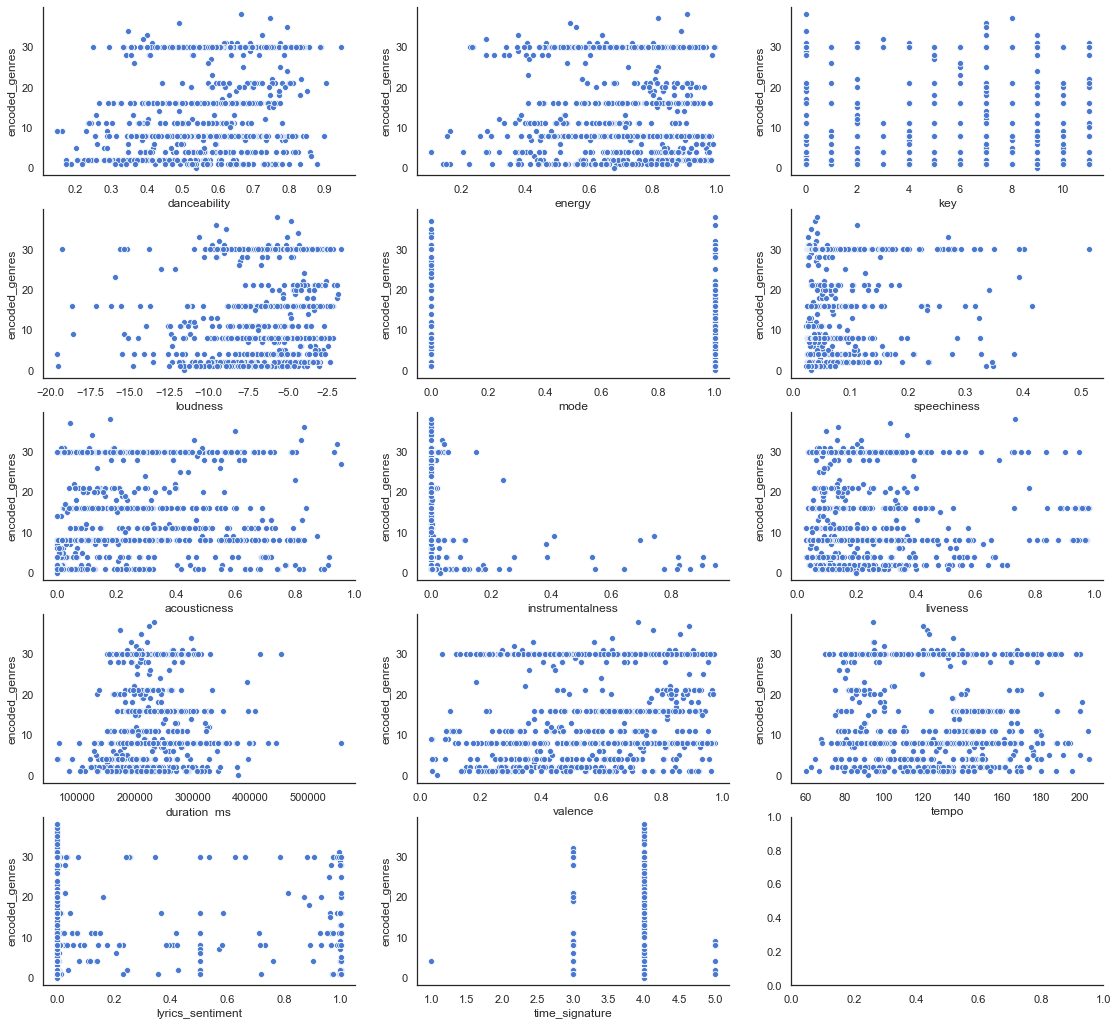

In [39]:
import warnings
warnings.filterwarnings('ignore')
sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(5, 3, figsize=(19, 18), sharex=False)
sns.despine()
f.suptitle("")
# Plots
sns.scatterplot(dataframe_working.danceability,dataframe_working['encoded_genres'], ax=axes[0, 0])
sns.scatterplot(dataframe_working.energy,dataframe_working['encoded_genres'], ax=axes[0, 1])
sns.scatterplot(dataframe_working.key,dataframe_working['encoded_genres'], ax=axes[0, 2])
sns.scatterplot(dataframe_working.loudness,dataframe_working['encoded_genres'], ax=axes[1, 0])
sns.scatterplot(dataframe_working['mode'],dataframe_working['encoded_genres'], ax=axes[1, 1])
sns.scatterplot(dataframe_working.speechiness,dataframe_working['encoded_genres'], ax=axes[1, 2])
sns.scatterplot(dataframe_working.acousticness,dataframe_working['encoded_genres'], ax=axes[2, 0])
sns.scatterplot(dataframe_working.instrumentalness,dataframe_working['encoded_genres'], ax=axes[2, 1])
sns.scatterplot(dataframe_working.liveness,dataframe_working['encoded_genres'], ax=axes[2, 2])
sns.scatterplot(dataframe_working.duration_ms ,dataframe_working['encoded_genres'], ax=axes[3, 0])
sns.scatterplot(dataframe_working.valence,dataframe_working['encoded_genres'], ax=axes[3, 1])
sns.scatterplot(dataframe_working.tempo,dataframe_working['encoded_genres'], ax=axes[3, 2])
sns.scatterplot(dataframe_working.lyrics_sentiment,dataframe_working['encoded_genres'], ax=axes[4, 0])
sns.scatterplot(dataframe_working.time_signature,dataframe_working['encoded_genres'], ax=axes[4, 1])

## Features Correlation

Correlation between all the features in the dataset

[Text(0.5, 0, 'lyrics_sentiment'),
 Text(1.5, 0, 'danceability'),
 Text(2.5, 0, 'energy'),
 Text(3.5, 0, 'key'),
 Text(4.5, 0, 'loudness'),
 Text(5.5, 0, 'mode'),
 Text(6.5, 0, 'speechiness'),
 Text(7.5, 0, 'acousticness'),
 Text(8.5, 0, 'instrumentalness'),
 Text(9.5, 0, 'liveness'),
 Text(10.5, 0, 'valence'),
 Text(11.5, 0, 'tempo'),
 Text(12.5, 0, 'duration_ms'),
 Text(13.5, 0, 'time_signature'),
 Text(14.5, 0, 'encoded_genres')]

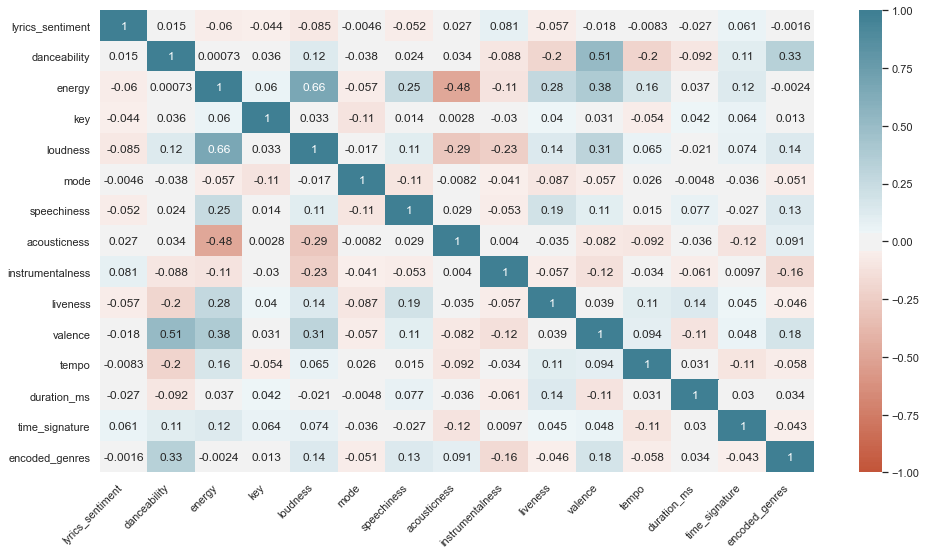

In [40]:
corr = dataframe_working.corr()
plt.figure(figsize=(16,8.5))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), #'coolwarm'
    square=False,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

# Classifier
#### Using Accuracy as a control score in Train and Test sets.
Representa el ratio entre predicciones correctas y total de predicciones (o tamaño del conjunto de entrenamiento). Esta medida funciona bien si existe una cantidad relativamente equivalente de entradas pertenecientes a cada clase, en caso contrario no será confiable o representativo. Esto puede verse por ejemplo en un caso donde el 98% de las entradas del conjunto de entrenamiento son negativas (en contraposición a positivas). En tal situación un modelo que realice todas predicciones negativas tendrá un accuracy de 98%. Si se tratara de un diagnóstico médico, confiar en un modelo que predice de esta forma sería un grave error en tanto existirán dos falsos negativos cuya salud podrá verse comprometida.
#### Precision:  
se define como la proporción entre verdaderos positivos y el total de predicciones postivas (verdaderos positivos + Falsos Positivos). En general, existe un trade-off entre Recall y Precision. Si todas las predicciones son positivas tendré una tasa de Recall de 100%. Sin embargo, esto afectaría la precision en tanto incrementaría la cantidad de falsos positivos.
#### Recall:
True Positive Rate se define como la proporción entre verdaderos positivos (predicciones positivas correctas) y el total de positivos en la muestra (Verdaderos Positivos + Falsos Negativos)
#### F1: 
Ees la media harmónica entre Recall y Precision. Se basa en la idea del trade-off entre estas métricas anteriormente mencionado. Mientras más cerca de 1 se encuentre F1 mejor será el desempeño del modelo.

###### _Average: string, [None, ‘micro’, ‘macro’ (default), ‘samples’, ‘weighted’]
If None, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data:

'micro':
        Calculate metrics globally by considering each element of the label indicator matrix as a label.

'macro':
        Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted':
        Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).

'samples':
         Calculate metrics for each instance, and find their average.


Will be ignored when y_true is binary.

#### Confusion matrix:
On each of the algorithms trained with the default parameters as a visual performance control tool.

In [41]:
#Classifier
import xgboost as xgb
from sklearn import ensemble
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
import sklearn.linear_model
import sklearn.neural_network
from sklearn import model_selection, tree

#Metrics
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    multilabel_confusion_matrix,
    plot_confusion_matrix,
    classification_report
)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
from sklearn import decomposition

initializing some models

In [42]:
xgb_clf=xgb.XGBClassifier(random_state=42)
dt_clf=DecisionTreeClassifier(random_state=42) 
sgd_clf=SGDClassifier(random_state=42)
rf_clf=RandomForestClassifier(random_state=42)
kn_clf=KNeighborsClassifier() #existe un parametro equivalente a random_state para kn?
svc_clf=svm.LinearSVC(random_state=42)

auxiliary function to plot confusion matrix

In [43]:
def plot_cm(y_true, y_pred, figsize=(20,9)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    cm_perc = np.nan_to_num(cm_perc,nan=0.)
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='coolwarm') #Blues BuPu Greens coolwarm
    plt.title('Confusion Matrix in TEST SPLIT', fontsize = 20)

here we start to train some models

## XGBOOST

-TRAIN
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
-TEST
Accuracy Score : 0.5217
Precision Score : 0.2124
Recall Score : 0.2149
F1 Score:0.2023

-Default parameters in the trained model:
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

-Classification Report Test Split:
              precision    recall  f1-score   support

           1       0.33      0.31      0.32        13
     

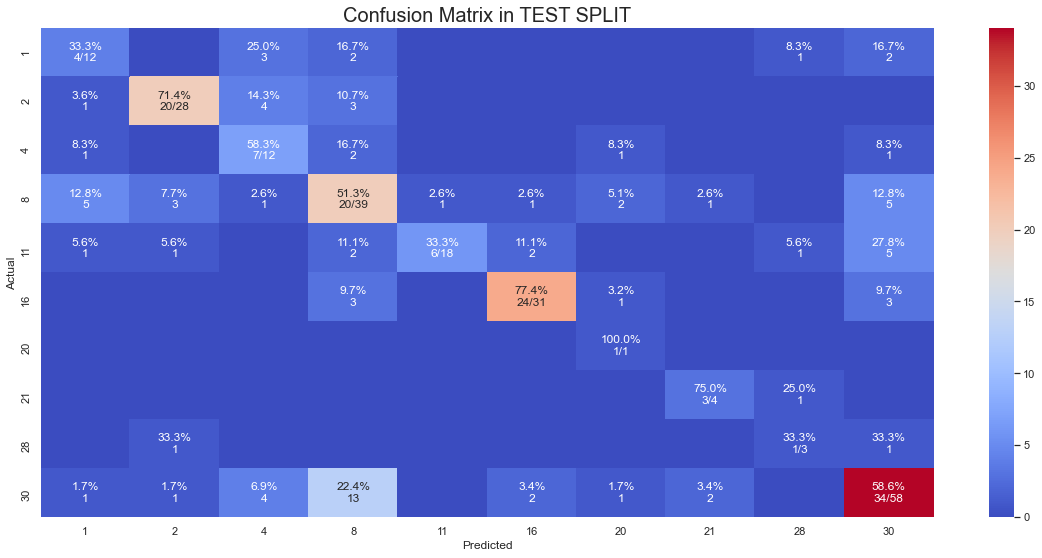

In [44]:
xgb_clf.fit(X_train, y_train)
y_train_pred_xgb = xgb_clf.predict(X_train)
y_test_pred_xgb = xgb_clf.predict(X_test)

print("\033[1m-TRAIN\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y_train, y_train_pred_xgb),4)))
print('Precision Score : ' + str(round(precision_score(y_train, y_train_pred_xgb,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y_train, y_train_pred_xgb,average='macro'),4)))
print('F1 Score : ' + str(round(f1_score(y_train, y_train_pred_xgb,average='macro'),4)))
print("\033[1m-TEST\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y_test, y_test_pred_xgb),4)))
print('Precision Score : ' + str(round(precision_score(y_test, y_test_pred_xgb,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y_test, y_test_pred_xgb,average='macro'),4)))
print('F1 Score:' + str(round(f1_score(y_test, y_test_pred_xgb,average='macro'),4)))
print("\n\033[1m-Default parameters in the trained model:\033[0m\n ", xgb_clf)
print("\n\033[1m-Classification Report Test Split:\033[0m")
print(classification_report(y_test, y_test_pred_xgb))
plot_cm(y_test_pred_xgb, y_test)

### Descriptive analysis of the results

The metrics hint us of a very probable overfitting. Not many classes were in the training data itself, so one present in the test data, the model was not able to predict correctly their class. The more represented cases were classified correctly on most cases, but the model doesn't have a clear picture of the data involved.

### PCA with XGBoost Classifier splits

<Figure size 432x288 with 0 Axes>

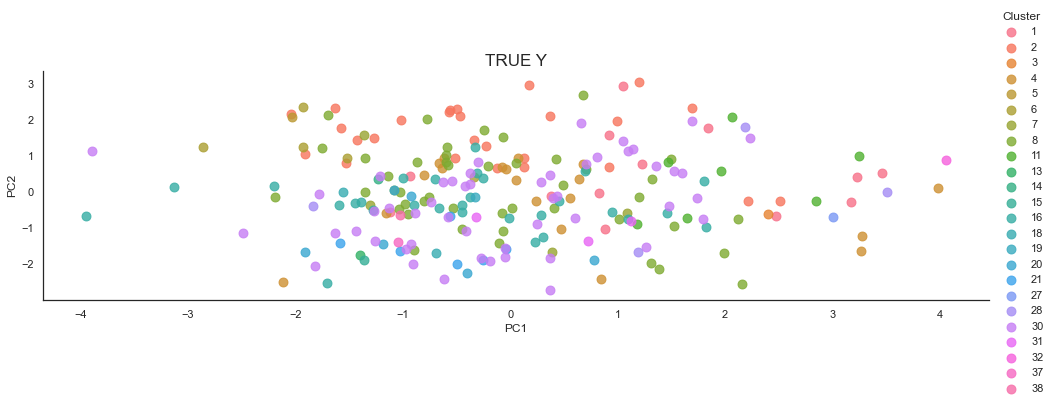

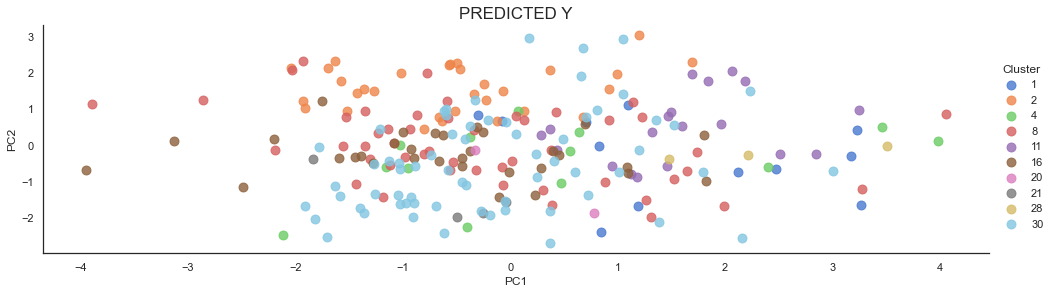

In [45]:
x_test_xgb = X_test
#TRUE
y_test_xgb = y_test
#PREDICTED
y_test_pred_xgb

pca = decomposition.PCA(n_components=2)
pc1 = pca.fit_transform(x_test_xgb)
pc2 = pca.fit_transform(x_test_xgb)
df_pca1 = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC': ['PC1','PC2']})
df_pca2 = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC': ['PC1','PC2']})

pc_df1 = pd.DataFrame(data=pc1, columns=['PC1', 'PC2'])
pc_df1['Cluster']=y_test_xgb.to_list()
pc_df2 = pd.DataFrame(data=pc2, columns=['PC1', 'PC2'])
pc_df2['Cluster']=y_test_pred_xgb

plt.figure()
sns.lmplot(x='PC1', y='PC2', data=pc_df1,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("TRUE Y", fontsize=17)

sns.lmplot(x='PC1', y='PC2', data=pc_df2,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("PREDICTED Y", fontsize=17)
plt.show()

### Descriptive analysis

When comparing these graphics we can see that 
- the model picks from a subset of the true set of genres. That has to do with their absence during training (for more of this issue see Problems Found section and the final report).
- the model was able to correctly classify samples of the class 1 in some cases, but not every time. The same happens for the class 30 and class 11. With that class as an example, we can conclude it was not able to generalize completely, but it could extract some information.


We have lost some interpretability in doing this PCA so we can't analyse wether the grouping of the cases in the lower half of the graph corresponds to some generalization the model tried to do, or it was because of a lack of data and lost subtleity.

## DecisionTreeClassifier

-TRAIN
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
-TEST
Accuracy Score : 0.3478
Precision Score : 0.1278
Recall Score : 0.114
F1 Score:0.1083

-Default parameters in the trained model:
  DecisionTreeClassifier(random_state=42)

-Classification Report Test Split:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        13
           2       0.57      0.65      0.61        26
           3       0.00      0.00      0.00         1
           4       0.38      0.32      0.34        19
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         4
           8       0.23      0.27      0.24        45
           9       0.00      0.00      0.00         0
          11       0.27      0.57      0.36         7
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         1


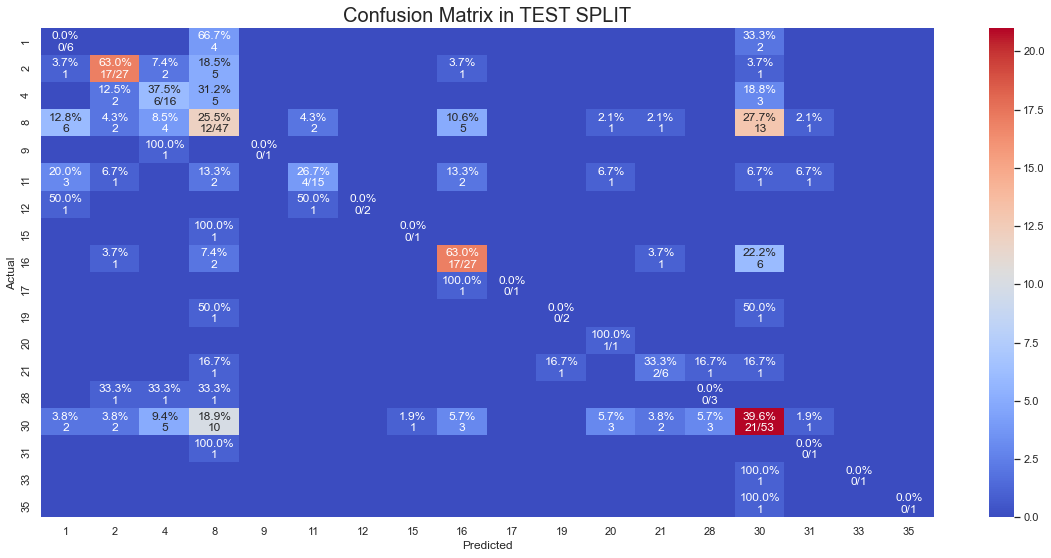

In [46]:
dt_clf.fit(X_train, y_train)
y_train_pred_dt = dt_clf.predict(X_train)
y_test_pred_dt = dt_clf.predict(X_test)

print("\033[1m-TRAIN\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y_train, y_train_pred_dt),4)))
print('Precision Score : ' + str(round(precision_score(y_train, y_train_pred_dt,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y_train, y_train_pred_dt,average='macro'),4)))
print('F1 Score : ' + str(round(f1_score(y_train, y_train_pred_dt,average='macro'),4)))
print("\033[1m-TEST\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y_test, y_test_pred_dt),4)))
print('Precision Score : ' + str(round(precision_score(y_test, y_test_pred_dt,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y_test, y_test_pred_dt,average='macro'),4)))
print('F1 Score:' + str(round(f1_score(y_test, y_test_pred_dt,average='macro'),4)))
print("\n\033[1m-Default parameters in the trained model:\033[0m\n ", dt_clf)
print("\n\033[1m-Classification Report Test Split:\033[0m")
print(classification_report(y_test, y_test_pred_dt))
plot_cm(y_test_pred_dt, y_test)

### Descriptive analysis of the results

We get even lower scores with this model. There was overfitting too and it wasn't able to learn from the most represented classes, but it predicted a wider range of classes. This may be because upon the situation of having small amounts of a lot of classes, the model "sacrificed" points of its score in order to get a more representative output (even if not precise, as a tradeoff).

This can be seen in the confusion matrix, which presents a lot of false positives and false negatives in the two classes that stand out: the 8 class and 30 class, two classes that were probably overrepresented on the training data.

### PCA with Decision Tree Classifier Splits

<Figure size 432x288 with 0 Axes>

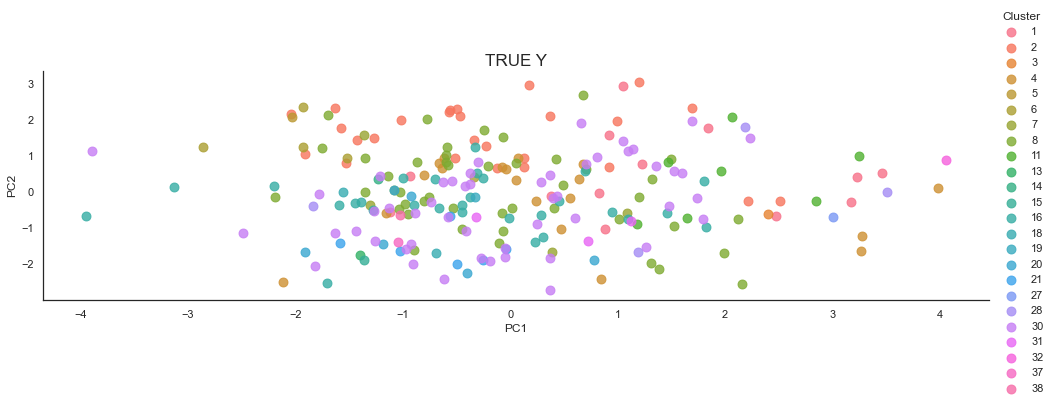

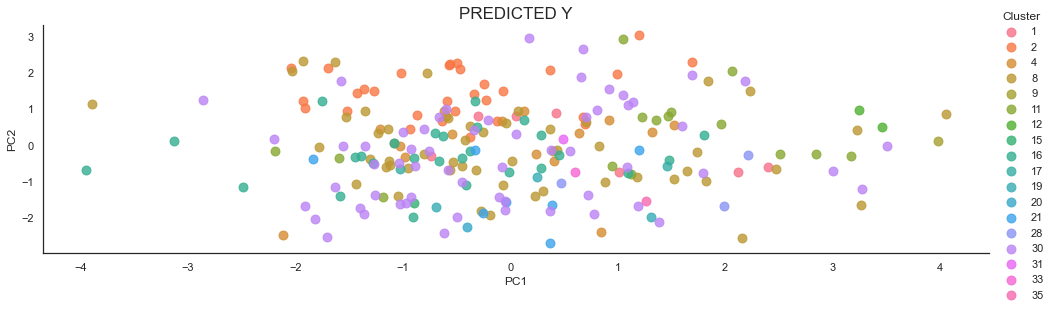

In [47]:
x_test_dt = X_test
#TRUE
y_test_dt = y_test
#PREDICTED
y_test_pred_dt

pca = decomposition.PCA(n_components=2)
pc1 = pca.fit_transform(x_test_dt)
pc2 = pca.fit_transform(x_test_dt)
df_pca1 = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC': ['PC1','PC2']})
df_pca2 = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC': ['PC1','PC2']})
#true
pc_df1 = pd.DataFrame(data=pc1, columns=['PC1', 'PC2'])
pc_df1['Cluster']=y_test_dt.to_list()
#predicted
pc_df2 = pd.DataFrame(data=pc2, columns=['PC1', 'PC2'])
pc_df2['Cluster']=y_test_pred_dt

plt.figure()
sns.lmplot(x='PC1', y='PC2', data=pc_df1,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("TRUE Y", fontsize=17)

sns.lmplot(x='PC1', y='PC2', data=pc_df2,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("PREDICTED Y", fontsize=17)
plt.show()

### Descriptive Analysis

These two graphs are more similiar than the ones that we obtained with the xgboost model, this let's us confirm the suspicion of the score/representativeness trade-off. The predicted classes are still a subset of the true classes, but its range is bigger. This presents the case of a more useful model: even against the scoring, with a more carefully curated dataset, this looks promising. We can see that even if some classes weren't accurately predicted, the songs that were of the same class A were grouped as having the same class by the model (with probably a wrong class B, B=/=A, but still remained grouped).

## SGDClassifier

-TRAIN
Accuracy Score : 0.4246
Precision Score : 0.5602
Recall Score : 0.4832
F1 Score : 0.4891
-TEST
Accuracy Score : 0.3261
Precision Score : 0.1318
Recall Score : 0.1378
F1 Score:0.1195

-Default parameters in the trained model:
  SGDClassifier(random_state=42)

-Classification Report Test Split:
              precision    recall  f1-score   support

           1       0.50      0.08      0.13        13
           2       0.53      0.65      0.59        26
           3       0.00      0.00      0.00         1
           4       0.18      0.21      0.20        19
           5       0.50      1.00      0.67         1
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         4
           8       0.31      0.47      0.38        45
          11       0.11      0.29      0.16         7
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00       

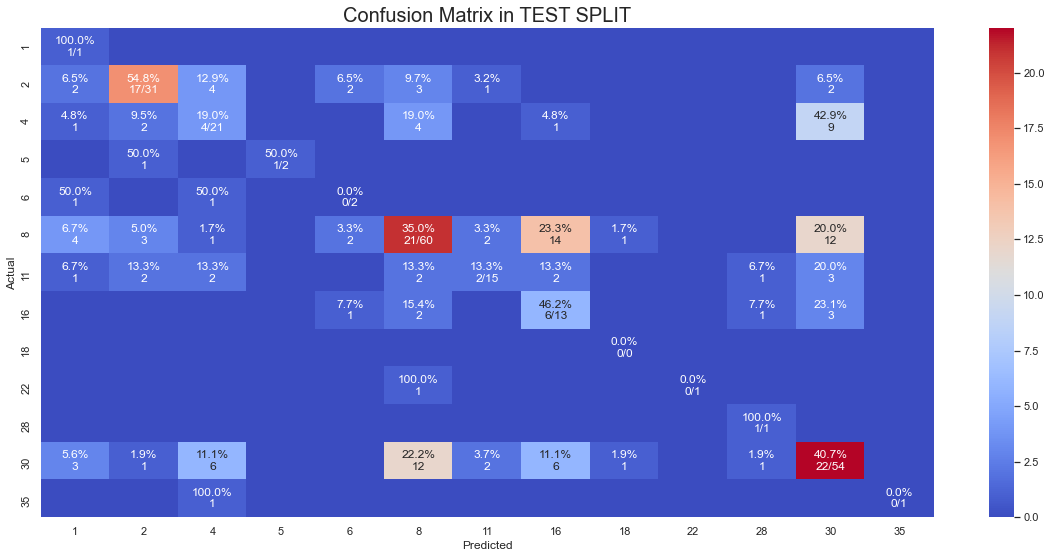

In [48]:
sgd_clf.fit(X_train, y_train)
y_train_pred_sgd = sgd_clf.predict(X_train)
y_test_pred_sgd = sgd_clf.predict(X_test)

print("\033[1m-TRAIN\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y_train, y_train_pred_sgd),4)))
print('Precision Score : ' + str(round(precision_score(y_train, y_train_pred_sgd,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y_train, y_train_pred_sgd,average='macro'),4)))
print('F1 Score : ' + str(round(f1_score(y_train, y_train_pred_sgd,average='macro'),4)))
print("\033[1m-TEST\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y_test, y_test_pred_sgd),4)))
print('Precision Score : ' + str(round(precision_score(y_test, y_test_pred_sgd,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y_test, y_test_pred_sgd,average='macro'),4)))
print('F1 Score:' + str(round(f1_score(y_test, y_test_pred_sgd,average='macro'),4)))
print("\n\033[1m-Default parameters in the trained model:\033[0m\n ", sgd_clf)
print("\n\033[1m-Classification Report Test Split:\033[0m")
print(classification_report(y_test, y_test_pred_sgd))
plot_cm(y_test_pred_sgd, y_test)

### Descriptive Analysis

The scores of this model show signs of less overfitting.

In the confusion matrix we can see there were in general more cases of false negatives and false positives. We can see a more distributed, generalized error, with no clear direction that the model took in order to circumvent the dataset problem.

## RandomForestClassifier

-TRAIN
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0
-TEST
Accuracy Score : 0.5261
Precision Score : 0.1697
Recall Score : 0.1681
F1 Score:0.1474

-Default parameters in the trained model:
  RandomForestClassifier(random_state=42)

-Classification Report Test Split:
              precision    recall  f1-score   support

           1       0.40      0.31      0.35        13
           2       0.65      0.85      0.73        26
           3       0.00      0.00      0.00         1
           4       1.00      0.05      0.10        19
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         4
           8       0.42      0.60      0.50        45
          11       0.50      0.86      0.63         7
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1

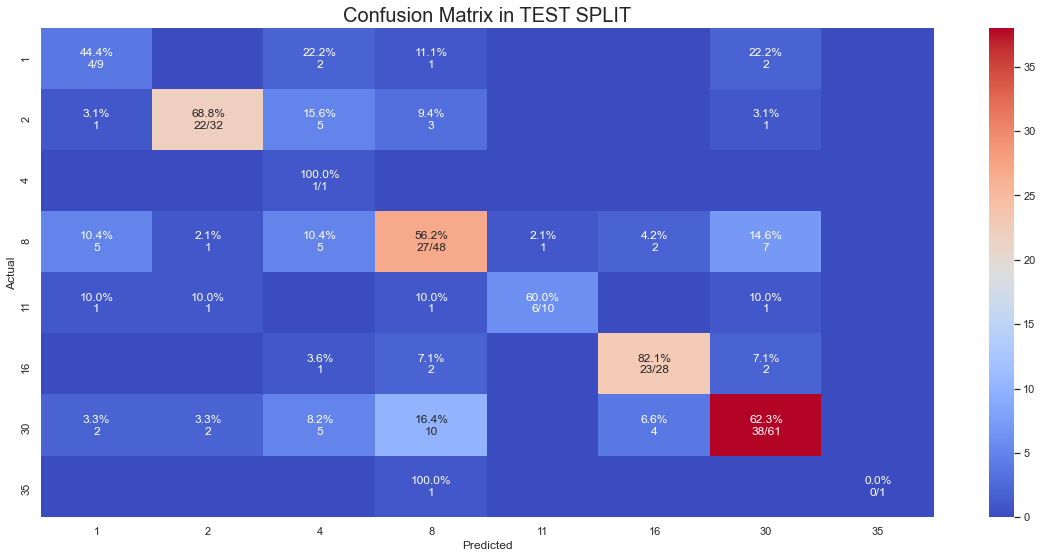

In [49]:
rf_clf.fit(X_train, y_train)
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

print("\033[1m-TRAIN\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y_train, y_train_pred_rf),4)))
print('Precision Score : ' + str(round(precision_score(y_train, y_train_pred_rf,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y_train, y_train_pred_rf,average='macro'),4)))
print('F1 Score : ' + str(round(f1_score(y_train, y_train_pred_rf,average='macro'),4)))
print("\033[1m-TEST\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y_test, y_test_pred_rf),4)))
print('Precision Score : ' + str(round(precision_score(y_test, y_test_pred_rf,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y_test, y_test_pred_rf,average='macro'),4)))
print('F1 Score:' + str(round(f1_score(y_test, y_test_pred_rf,average='macro'),4)))
print("\n\033[1m-Default parameters in the trained model:\033[0m\n ", rf_clf)
print("\n\033[1m-Classification Report Test Split:\033[0m")
print(classification_report(y_test, y_test_pred_rf))
plot_cm(y_test_pred_rf, y_test)

### Descriptive Analysis

There was also overfitting in this model, but it was able to correctly label the represented cases. This gives us hope that with a more carefully curated dataset, this model could learn to classify the songs into genres.

### PCA with Random Forest Classifier Splits

<Figure size 432x288 with 0 Axes>

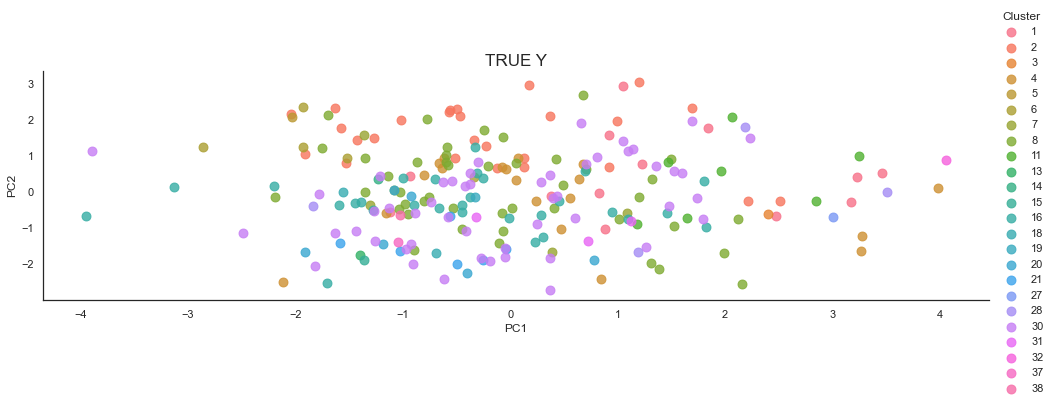

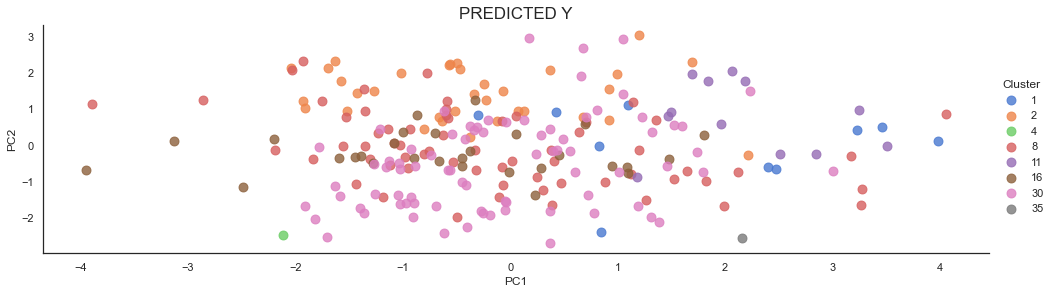

In [50]:
x_test_rf = X_test
#TRUE
y_test_rf = y_test
#PREDICTED
y_test_pred_rf

pca = decomposition.PCA(n_components=2)
pc1 = pca.fit_transform(x_test_rf)
pc2 = pca.fit_transform(x_test_rf)
df_pca1 = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC': ['PC1','PC2']})
df_pca2 = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC': ['PC1','PC2']})
#true
pc_df1 = pd.DataFrame(data=pc1, columns=['PC1', 'PC2'])
pc_df1['Cluster']=y_test_rf.to_list()
#predicted
pc_df2 = pd.DataFrame(data=pc2, columns=['PC1', 'PC2'])
pc_df2['Cluster']=y_test_pred_rf

plt.figure()
sns.lmplot(x='PC1', y='PC2', data=pc_df1,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("TRUE Y", fontsize=17)

sns.lmplot(x='PC1', y='PC2', data=pc_df2,fit_reg=False,hue='Cluster',legend=True, scatter_kws={"s":80},height=4, aspect=3.5)
ax = plt.gca()
ax.set_title("PREDICTED Y", fontsize=17)
plt.show()

### Descriptive Analysis

We see results in these graphics that reminds us of the first model (xgboost). 

The model lost subtlety, classifying in a more simplistic manner but also maintaining the same clusters. Like in the last case, the samples that belonged to a class A were classified as class B but remained together in its classification attempts.

## KNeighborsClassifier

-TRAIN
Accuracy Score : 0.5594
Precision Score : 0.1887
Recall Score : 0.1335
F1 Score : 0.1385
-TEST
Accuracy Score : 0.3913
Precision Score : 0.1426
Recall Score : 0.1168
F1 Score: 
0.1135

-Default parameters in the trained model:
  KNeighborsClassifier()

-Classification Report Test Split:
              precision    recall  f1-score   support

           1       0.12      0.15      0.14        13
           2       0.59      0.50      0.54        26
           3       0.00      0.00      0.00         1
           4       0.33      0.21      0.26        19
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         4
           8       0.36      0.64      0.46        45
          11       0.12      0.29      0.17         7
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
  

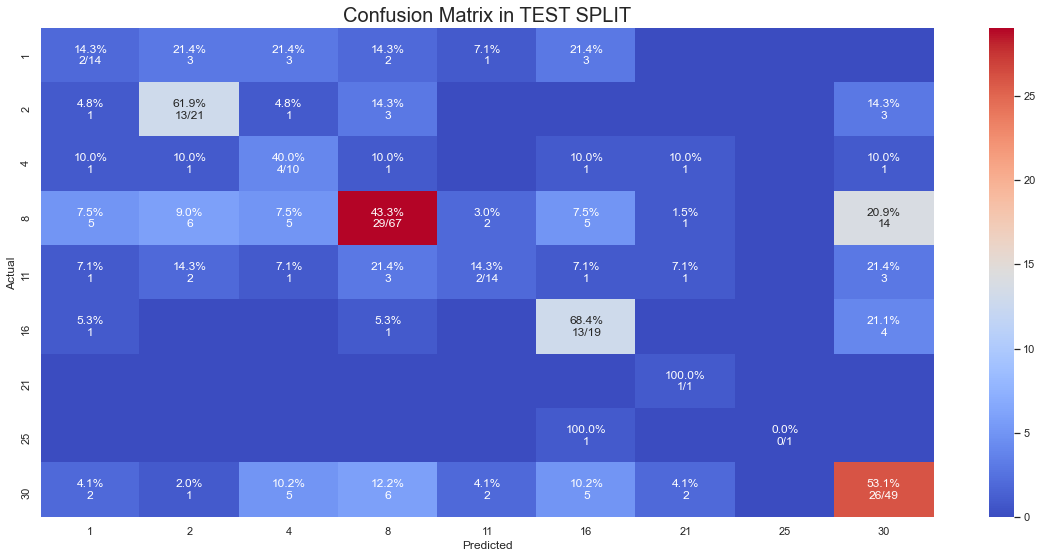

In [51]:
kn_clf.fit(X_train, y_train)
y_train_pred_kn = kn_clf.predict(X_train)
y_test_pred_kn = kn_clf.predict(X_test)

print("\033[1m-TRAIN\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y_train, y_train_pred_kn),4)))
print('Precision Score : ' + str(round(precision_score(y_train, y_train_pred_kn,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y_train, y_train_pred_kn,average='macro'),4)))
print('F1 Score : ' + str(round(f1_score(y_train, y_train_pred_kn,average='macro'),4)))
print("\033[1m-TEST\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y_test, y_test_pred_kn),4)))
print('Precision Score : ' + str(round(precision_score(y_test, y_test_pred_kn,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y_test, y_test_pred_kn,average='macro'),4)))
print('F1 Score: \n' + str(round(f1_score(y_test, y_test_pred_kn,average='macro'),4)))
print("\n\033[1m-Default parameters in the trained model:\033[0m\n ", kn_clf)
print("\n\033[1m-Classification Report Test Split:\033[0m")
print(classification_report(y_test, y_test_pred_kn))
plot_cm(y_test_pred_kn, y_test)

### Descriptive Analysis

This model also didn't overfit but it also didn't learn very much. The same remarks are valid for this model; it preferred to predict a narrower range of classes, occurring in a lot of errors both of false positive kind as of false negative kind.

## SVM.LinearSVC

-TRAIN
Accuracy Score : 0.4768
Precision Score : 0.2846
Recall Score : 0.2483
F1 Score : 0.2475
-TEST
Accuracy Score : 0.3696
Precision Score : 0.1218
Recall Score : 0.1124
F1 Score: 
0.0979

-Default parameters in the trained model:
  LinearSVC(random_state=42)

-Classification Report Test Split:
              precision    recall  f1-score   support

           1       0.50      0.08      0.13        13
           2       0.51      0.69      0.59        26
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         4
           8       0.32      0.51      0.39        45
           9       0.00      0.00      0.00         0
          11       0.27      0.57      0.36         7
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         

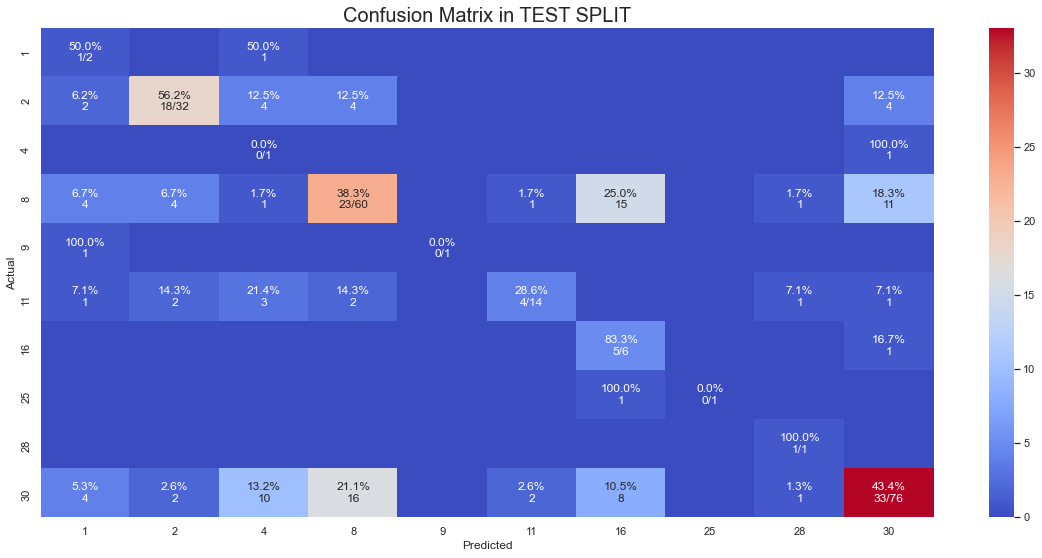

In [52]:
svc_clf.fit(X_train, y_train)
y_train_pred_svc = svc_clf.predict(X_train)
y_test_pred_svc = svc_clf.predict(X_test)

print("\033[1m-TRAIN\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y_train, y_train_pred_svc),4)))
print('Precision Score : ' + str(round(precision_score(y_train, y_train_pred_svc,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y_train, y_train_pred_svc,average='macro'),4)))
print('F1 Score : ' + str(round(f1_score(y_train, y_train_pred_svc,average='macro'),4)))
print("\033[1m-TEST\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y_test, y_test_pred_svc),4)))
print('Precision Score : ' + str(round(precision_score(y_test, y_test_pred_svc,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y_test, y_test_pred_svc,average='macro'),4)))
print('F1 Score: \n' + str(round(f1_score(y_test, y_test_pred_svc,average='macro'),4)))
print("\n\033[1m-Default parameters in the trained model:\033[0m\n ",svc_clf)
print("\n\033[1m-Classification Report Test Split:\033[0m")
print(classification_report(y_test, y_test_pred_svc))
plot_cm(y_test_pred_svc, y_test)

### Descriptive Analysis

In most cases, the same remarks apply. 
We can distinguish the cases:
    - the class 16, which the model learnt to detect correctly,
    - the classes 30, class 8, 4 and 2 could not be distinguised from one another.

## Feature Importance

It is of interest to see which strategies the models took in order to try to bypass the dataset limitations.

Let's see the different ways in which each model ranked the features' importance.

In [53]:
def plot_feature_importance(importance,names,model_type):
#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
#Define size of bar plot
    plt.figure(figsize=(13,5))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette="Blues_d") # GnBu  Blues_d
#Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

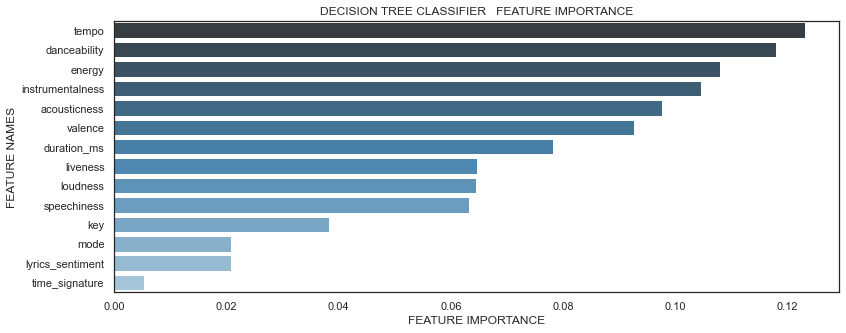

In [54]:
plot_feature_importance(dt_clf.feature_importances_, X_train.columns,'DECISION TREE CLASSIFIER   ')

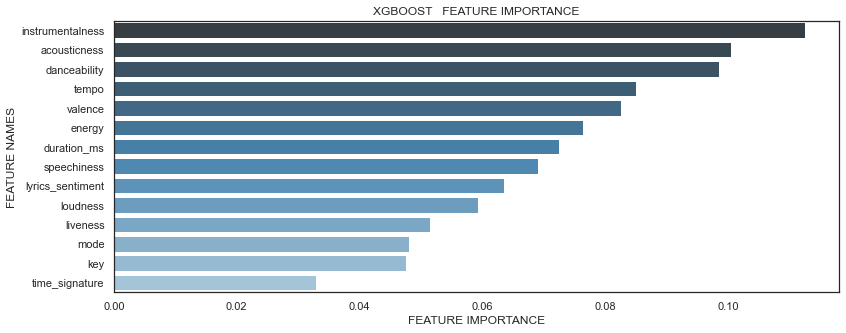

In [55]:
plot_feature_importance(xgb_clf.feature_importances_, X_train.columns,'XGBOOST   ')

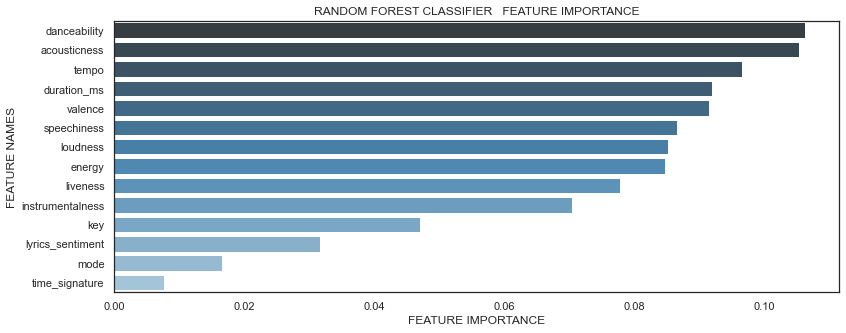

In [56]:
plot_feature_importance(rf_clf.feature_importances_, X_train.columns,'RANDOM FOREST CLASSIFIER   ')

## Multiclass + Multilabel

In [57]:
# XX2=Features YY2 list of genres, target multilabel without encoding
XX2,YY2 = get_df_for_training(songs_base)

In [58]:
XX2 = normalize_features(df=XX2)
print(XX2.shape)
XX2.head(3)

(920, 12)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,lyrics_sentiment
0,-2.795153,-1.374931,-1.231805,-1.739334,-1.281363,-0.319361,1.118705,4.028792,0.738738,-2.209803,1.175334,-0.412193
1,-2.336547,-1.644796,1.312942,-2.175529,-1.281363,-0.193645,1.479134,-0.177061,-0.536893,-2.250020,-1.511917,2.773773
2,-1.944405,-2.510613,1.030192,-3.248819,0.779571,-0.381424,2.783541,-0.131506,-0.492046,-2.443674,-0.038027,-0.416353


In [59]:
print(YY2.shape)
YY2.head(3)

(920,)


0    [art pop,  dance pop,  deconstructed club,  electropop,  escape room,  experimental pop,  fluxwork,  indie r&b,  indietronica]
1    [art pop,  dance pop,  deconstructed club,  electropop,  escape room,  experimental pop,  fluxwork,  indie r&b,  indietronica]
2    [art pop,  dance pop,  deconstructed club,  electropop,  escape room,  experimental pop,  fluxwork,  indie r&b,  indietronica]
Name: genres, dtype: object

In [60]:
binarizer = MultiLabelBinarizer()
yy2_binarized = binarizer.fit_transform(YY2)
X2_train, X2_test, y2_train, y2_test = model_selection.train_test_split(XX2, yy2_binarized , test_size=0.25, random_state=42)

## OneVsRestClassifier

In order to go about this in a multilabel multiclass way, we explore the OneVsRestClassifier with a SGDClassifier.

In [61]:
import warnings
warnings.filterwarnings('ignore')

param_grid_ovr = {
              "estimator__alpha": [10**-5, 10**-3, 10**-1, 10**1, 10**2],
    
             }

ovr_clf = OneVsRestClassifier(
                SGDClassifier(
                    random_state=42,
                    loss='perceptron', #'log'
                    alpha=0.00001,
                    penalty="l2",
                    n_jobs=-1
                )
                  )

grid_ovr= GridSearchCV(ovr_clf, param_grid_ovr, scoring='accuracy', cv=3, verbose=1)
grid_ovr.fit(X2_train, y2_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.9s finished


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05,
                                                                   loss='perceptron',
                                                                   n_jobs=-1,
                                                                   random_state=42)),
             param_grid={'estimator__alpha': [1e-05, 0.001, 0.1, 10, 100]},
             scoring='accuracy', verbose=1)

In [62]:
#making a prediction in train and test!
ovr_best_model = grid_ovr.best_estimator_
y2_train_pred_ovr = ovr_best_model.predict(X2_train)
y2_test_pred_ovr = ovr_best_model.predict(X2_test)

In [63]:
print("\033[1m-TRAIN\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y2_train, y2_train_pred_ovr),4)))
print('Precision Score : ' + str(round(precision_score(y2_train, y2_train_pred_ovr,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y2_train, y2_train_pred_ovr,average='macro'),4)))
print('F1 Score : ' + str(round(f1_score(y2_train, y2_train_pred_ovr,average='macro'),4)))
print("\033[1m-TEST\033[0m")
print('Accuracy Score : ' + str(round(accuracy_score(y2_test, y2_test_pred_ovr),4)))
print('Precision Score : ' + str(round(precision_score(y2_test, y2_test_pred_ovr,average='macro'),4)))
print('Recall Score : ' + str(round(recall_score(y2_test, y2_test_pred_ovr,average='macro'),4)))
print('F1 Score:' + str(round(f1_score(y2_test, y2_test_pred_ovr,average='macro'),4)))
print("\n\033[1m-Default parameters in the best trained model:\033[0m\n ", ovr_best_model)
print("\n\033[1m-Classification Report Test Split:\033[0m")
print(classification_report(y2_test, y2_test_pred_ovr))

-TRAIN
Accuracy Score : 0.0681
Precision Score : 0.003
Recall Score : 0.0217
F1 Score : 0.0052
-TEST
Accuracy Score : 0.0304
Precision Score : 0.0023
Recall Score : 0.0217
F1 Score:0.0039

-Default parameters in the best trained model:
  OneVsRestClassifier(estimator=SGDClassifier(alpha=100, loss='perceptron',
                                            n_jobs=-1, random_state=42))

-Classification Report Test Split:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        54
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00     

In [64]:
#param grid all combinations
results_ovr = grid_ovr.cv_results_
df_ovr = pd.DataFrame(results_ovr)
df_ovr.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.242666,0.016444,0.104017,0.001430,1e-05,{'estimator__alpha': 1e-05},0.004348,0.008696,0.004348,0.005797,0.002050,2
1,0.247010,0.010247,0.100003,0.003260,0.001,{'estimator__alpha': 0.001},0.008696,0.008696,0.000000,0.005797,0.004099,2
2,0.231988,0.006669,0.104997,0.004963,0.1,{'estimator__alpha': 0.1},0.004348,0.004348,0.004348,0.004348,0.000000,4


In [65]:
ovr_best_model.n_classes_

138

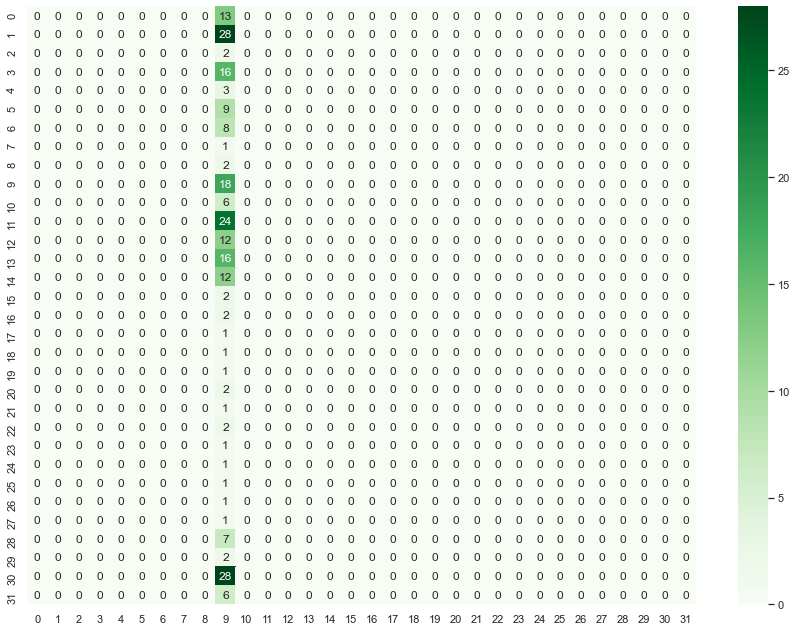

In [66]:
cm = confusion_matrix(y2_test.argmax(axis=1), y2_test_pred_ovr.argmax(axis=1), labels=np.unique(y2_test.argmax(axis=1)))
plt.figure(figsize=(15,11))
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap='Greens') #Blues Coolwarm Greens

### Descriptive Analysis

In this confusion matrix we can see that this model chose to only classify songs as having the genre of class 9. It would seem that it gave a better accuracy score to just outright take that decision than to try to give subtle distinctions. If retrained on changing the scoring hyperparameter to value something else than the accuracy (for ex average_precision), we see the accuracy drastically lowered but a more representative output follows.

That's the same kind of tradeoff all of the rest of the models had to put up with: the pull and push of generalizing vs giving a right answer for a very unbalanced unrepresentative dataset.

# Further reading and conclusions

More backstory and reflexions on what has been discussed here can be found on the main report.

The unbalanced nature of the dataset presented a choice to be taken by the models: to memorize the few classes that were shown to them in order to maximize the scoring (at the cost of predicting in a non representative way), or try to maintain some subtlety (at the cost of lower scoring).